In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from collections import defaultdict

In [58]:
# Пути к файлам
movies_path = 'movies (1).csv'
ratings_path = 'ratings 2.csv'

movies_df = pd.read_csv(movies_path)
ratings_df = pd.read_csv(ratings_path)

movies_df.dropna(subset=['title', 'genres'], inplace=True)
movies_df['genres'] = movies_df['genres'].str.replace('|', ' ')
movies_df['content'] = movies_df['title'] + ' ' + movies_df['genres']

print("Movies DataFrame:")
print(movies_df.head())
print("\nRatings DataFrame:")
print(ratings_df.head())

Movies DataFrame:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure Animation Children Comedy Fantasy   
1                   Adventure Children Fantasy   
2                               Comedy Romance   
3                         Comedy Drama Romance   
4                                       Comedy   

                                             content  
0  Toy Story (1995) Adventure Animation Children ...  
1          Jumanji (1995) Adventure Children Fantasy  
2             Grumpier Old Men (1995) Comedy Romance  
3      Waiting to Exhale (1995) Comedy Drama Romance  
4          Father of the Bride Part II (1995) Comedy  

Ratings DataFrame:
   userId  movieId  rating  ti

In [64]:
def item_based_collaborative_filtering(ratings_df, movies_df, user_id, top_n=5):
    # Создаем user-item матрицу
    user_item_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    
    # Косинусное сходство между фильмами
    item_similarity = cosine_similarity(user_item_matrix.T)
    item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)
    
    # Получаем рейтинги пользователя
    user_ratings = user_item_matrix.loc[user_id]
    rated_items = user_ratings[user_ratings > 0].index
    
    # Находим похожие фильмы
    scores = pd.Series(0.0, index=user_item_matrix.columns)
    for item in rated_items:
        similar_scores = item_similarity_df[item] * user_ratings[item]
        scores = scores.add(similar_scores, fill_value=0)
    
    # Исключаем уже оцененные фильмы
    scores = scores.drop(rated_items, errors='ignore')
    
    # Получаем топ-N рекомендаций
    top_items = scores.sort_values(ascending=False).head(top_n)
    recommendations = movies_df[movies_df['movieId'].isin(top_items.index)][['movieId', 'title']]
    
    return recommendations

# Пример для userId=1
print("\nItem-based Recommendations for User 1:")
print(item_based_collaborative_filtering(ratings_df, movies_df, user_id=1, top_n=10))


Item-based Recommendations for User 1:
      movieId                                         title
507       589             Terminator 2: Judgment Day (1991)
706       924                  2001: A Space Odyssey (1968)
793      1036                               Die Hard (1988)
902      1200                                 Aliens (1986)
1071     1391                          Mars Attacks! (1996)
1158     1527                     Fifth Element, The (1997)
1445     1968                    Breakfast Club, The (1985)
2014     2683  Austin Powers: The Spy Who Shagged Me (1999)
2078     2762                       Sixth Sense, The (1999)
2195     2918               Ferris Bueller's Day Off (1986)


In [62]:
def user_based_collaborative_filtering(ratings_df, movies_df, user_id, top_n=5):
    # Создаем user-item матрицу
    user_item_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    
    # Косинусное сходство между пользователями
    user_similarity = cosine_similarity(user_item_matrix)
    user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)
    
    # Находим похожих пользователей
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:11]  # Топ-10 похожих
    
    # Получаем фильмы, которые понравились похожим пользователям
    recommendations = pd.Series(dtype=float)
    for sim_user, similarity in similar_users.items():
        user_ratings = user_item_matrix.loc[sim_user]
        rated_items = user_ratings[user_ratings > 0]
        recommendations = recommendations.add(rated_items * similarity, fill_value=0)
    
    # Исключаем фильмы, которые пользователь уже оценил
    user_rated = user_item_matrix.loc[user_id]
    recommendations = recommendations[user_rated == 0]
    
    # Топ-N рекомендаций
    top_items = recommendations.sort_values(ascending=False).head(top_n).index
    recommendations = movies_df[movies_df['movieId'].isin(top_items)][['movieId', 'title']]
    
    return recommendations

# Пример для userId=1
print("\nUser-based Recommendations for User 1:")
print(user_based_collaborative_filtering(ratings_df, movies_df, user_id=1, top_n=10))


User-based Recommendations for User 1:
      movieId                              title
474       541                Blade Runner (1982)
507       589  Terminator 2: Judgment Day (1991)
659       858              Godfather, The (1972)
706       924       2001: A Space Odyssey (1968)
793      1036                    Die Hard (1988)
902      1200                      Aliens (1986)
922      1221     Godfather: Part II, The (1974)
1211     1610   Hunt for Red October, The (1990)
1445     1968         Breakfast Club, The (1985)
2078     2762            Sixth Sense, The (1999)


In [63]:
def content_based_filtering(ratings_df, movies_df, user_id, top_n=5):
    # TF-IDF векторизация
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(movies_df['content'])
    
    # Косинусное сходство между фильмами
    content_similarity = cosine_similarity(tfidf_matrix)
    content_similarity_df = pd.DataFrame(content_similarity, index=movies_df['movieId'], columns=movies_df['movieId'])
    
    # Получаем фильмы, которые пользователь оценил высоко (рейтинг >= 4)
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    high_rated = user_ratings[user_ratings['rating'] >= 4]['movieId']
    
    # Находим похожие фильмы
    scores = pd.Series(0.0, index=movies_df['movieId'])
    for movie_id in high_rated:
        similar_scores = content_similarity_df[movie_id]
        scores = scores.add(similar_scores, fill_value=0)
    
    # Исключаем уже оцененные фильмы
    scores = scores.drop(high_rated, errors='ignore')
    
    # Топ-N рекомендаций
    top_items = scores.sort_values(ascending=False).head(top_n).index
    recommendations = movies_df[movies_df['movieId'].isin(top_items)][['movieId', 'title']]
    
    return recommendations

# Пример для userId=1
print("\nContent-based Recommendations for User 1:")
print(content_based_filtering(ratings_df, movies_df, user_id=1, top_n=10))


Content-based Recommendations for User 1:
      movieId                              title
422       485            Last Action Hero (1993)
656       849            Escape from L.A. (1996)
1972     2617                  Mummy, The (1999)
2815     3763                         F/X (1986)
5396     9004                  D.A.R.Y.L. (1985)
5533    26590         G.I. Joe: The Movie (1987)
5620    27155  Batman/Superman Movie, The (1998)
6140    43917                 Eight Below (2006)
6330    48774             Children of Men (2006)
8806   130520                        Home (2015)


In [71]:
# Функция для Гибридной фильтрации
def hybrid_filtering(train_ratings, movies_df, user_id, top_n=5, weights=None):
    if weights is None:
        weights = {'item_based': 0.4, 'user_based': 0.3, 'content_based': 0.3}
    
    item_based_recs = item_based_collaborative_filtering(train_ratings, movies_df, user_id, top_n=top_n*3)
    user_based_recs = user_based_collaborative_filtering(train_ratings, movies_df, user_id, top_n=top_n*3)
    content_based_recs = content_based_filtering(train_ratings, movies_df, user_id, top_n=top_n*3)
    
    movie_scores = {}
    for _, row in item_based_recs.iterrows():
        movie_id = row['movieId']
        movie_scores[movie_id] = movie_scores.get(movie_id, 0) + weights['item_based'] * (1 / (1 + list(item_based_recs['movieId']).index(movie_id)))
    
    for _, row in user_based_recs.iterrows():
        movie_id = row['movieId']
        movie_scores[movie_id] = movie_scores.get(movie_id, 0) + weights['user_based'] * (1 / (1 + list(user_based_recs['movieId']).index(movie_id)))
    
    for _, row in content_based_recs.iterrows():
        movie_id = row['movieId']
        movie_scores[movie_id] = movie_scores.get(movie_id, 0) + weights['content_based'] * (1 / (1 + list(content_based_recs['movieId']).index(movie_id)))
    
    hybrid_scores = pd.DataFrame(list(movie_scores.items()), columns=['movieId', 'score'])
    hybrid_scores = hybrid_scores.sort_values(by='score', ascending=False).head(top_n)
    recommendations = movies_df[movies_df['movieId'].isin(hybrid_scores['movieId'])][['movieId', 'title']]
    
    return recommendations

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Разделение данных
train_ratings, test_ratings = train_test_split(ratings_df, test_size=0.2, random_state=42)

# Проверка размеров
print(f"Train size: {len(train_ratings)}, Test size: {len(test_ratings)}")

Train size: 80668, Test size: 20168


In [72]:
def evaluate_recommendations(recommended_items, true_items, k=5):
    recommended_k = recommended_items[:k]
    relevant = set(true_items)
    recommended_set = set(recommended_k)
    
    true_positive = len(recommended_set & relevant)
    precision = true_positive / k if k > 0 else 0
    recall = true_positive / len(relevant) if len(relevant) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

In [ ]:
# Функция для оценки всех моделей
from sklearn.metrics import mean_squared_error


def evaluate_models(train_ratings, test_ratings, movies_df, k=5):
    results = {'Model': [], 'Precision@K': [], 'Recall@K': [], 'F1@K': [], 'RMSE': []}
    
    test_high_rated = test_ratings[test_ratings['rating'] >= 4][['userId', 'movieId']]
    user_true_items = test_high_rated.groupby('userId')['movieId'].apply(list).to_dict()
    
    global_mean_rating = train_ratings['rating'].mean()
    test_users = test_ratings['userId'].unique()
    
    for model_name in ['Item-based', 'User-based', 'Content-based', 'Hybrid']:
        precisions, recalls, f1s, rmses = [], [], [], []
        
        for user_id in test_users[:100]:
            if model_name == 'Item-based':
                recommendations = item_based_collaborative_filtering(train_ratings, movies_df, user_id, top_n=k)
            elif model_name == 'User-based':
                recommendations = user_based_collaborative_filtering(train_ratings, movies_df, user_id, top_n=k)
            elif model_name == 'Content-based':
                recommendations = content_based_filtering(train_ratings, movies_df, user_id, top_n=k)
            else:
                recommendations = hybrid_filtering(train_ratings, movies_df, user_id, top_n=k)
            
            recommended_items = recommendations['movieId'].tolist()
            true_items = user_true_items.get(user_id, [])
            
            if true_items:
                precision, recall, f1 = evaluate_recommendations(recommended_items, true_items, k)
                precisions.append(precision)
                recalls.append(recall)
                f1s.append(f1)
            
            if model_name in ['Item-based', 'User-based', 'Hybrid']:
                user_test_ratings = test_ratings[test_ratings['userId'] == user_id]
                true_ratings = user_test_ratings['rating'].values
                predicted_ratings = []
                
                for _, row in user_test_ratings.iterrows():
                    movie_id = row['movieId']
                    if model_name == 'Item-based':
                        pred_rating = train_ratings[train_ratings['movieId'] == movie_id]['rating'].mean()
                    elif model_name == 'User-based':
                        pred_rating = train_ratings[train_ratings['movieId'] == movie_id]['rating'].mean()
                    else:
                        item_pred = train_ratings[train_ratings['movieId'] == movie_id]['rating'].mean()
                        user_pred = train_ratings[train_ratings['movieId'] == movie_id]['rating'].mean()
                        pred_rating = (item_pred + user_pred) / 2 if not (pd.isna(item_pred) or pd.isna(user_pred)) else global_mean_rating
                    
                    pred_rating = pred_rating if not pd.isna(pred_rating) else global_mean_rating
                    predicted_ratings.append(pred_rating)
                
                if predicted_ratings and not np.any(np.isnan(true_ratings)):
                    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
                    rmses.append(rmse)
        
        results['Model'].append(model_name)
        results['Precision@K'].append(np.mean(precisions) if precisions else 0)
        results['Recall@K'].append(np.mean(recalls) if recalls else 0)
        results['F1@K'].append(np.mean(f1s) if f1s else 0)
        results['RMSE'].append(np.mean(rmses) if rmses else np.nan)
    
    return pd.DataFrame(results)

In [74]:
results_df = evaluate_models(train_ratings, test_ratings, movies_df, k=5)
print("\nModel Evaluation Results:")
print(results_df)


Model Evaluation Results:
           Model  Precision@K  Recall@K      F1@K      RMSE
0     Item-based        0.302  0.081900  0.102191  0.958401
1     User-based        0.346  0.092900  0.117542  0.958401
2  Content-based        0.016  0.003073  0.004535       NaN
3         Hybrid        0.256  0.058667  0.081669  0.958401


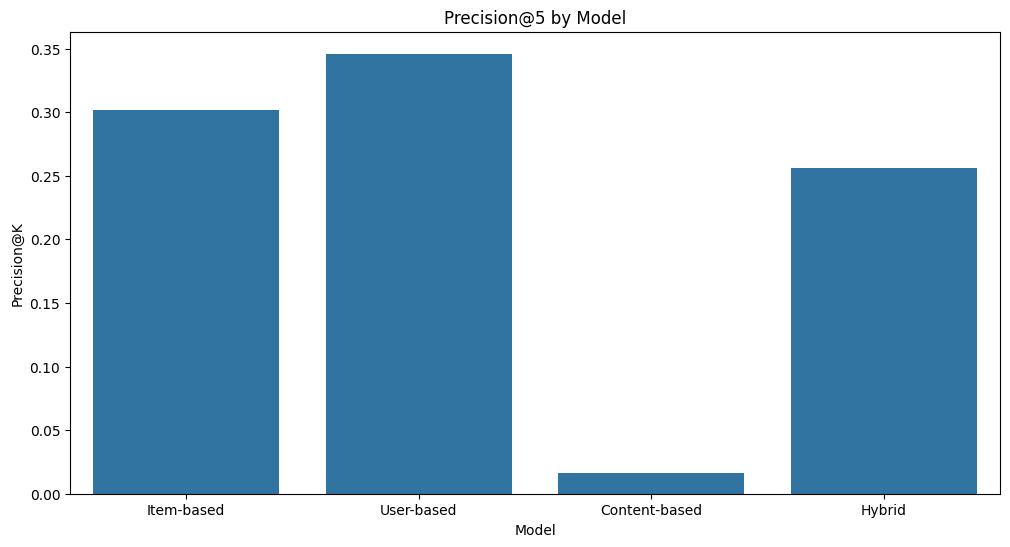

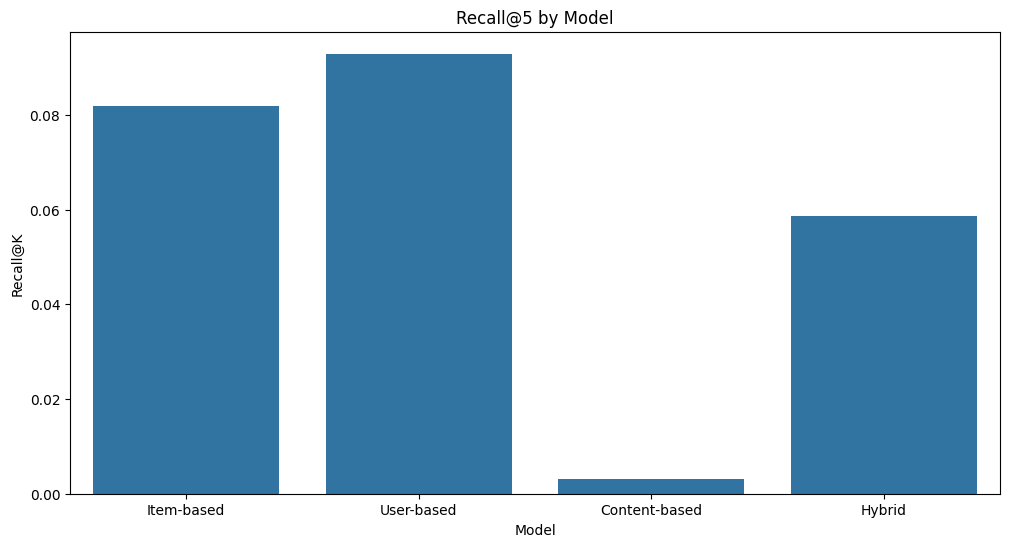

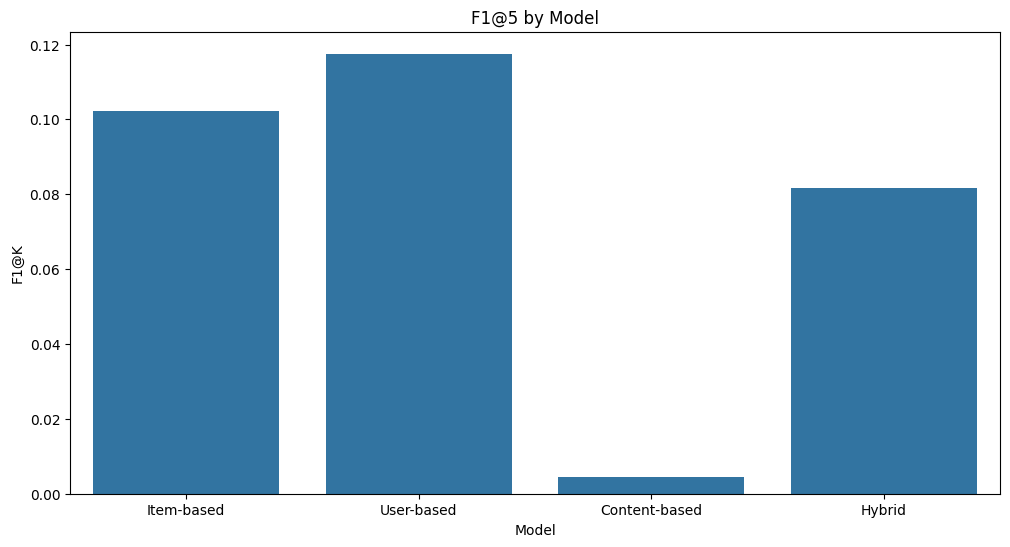

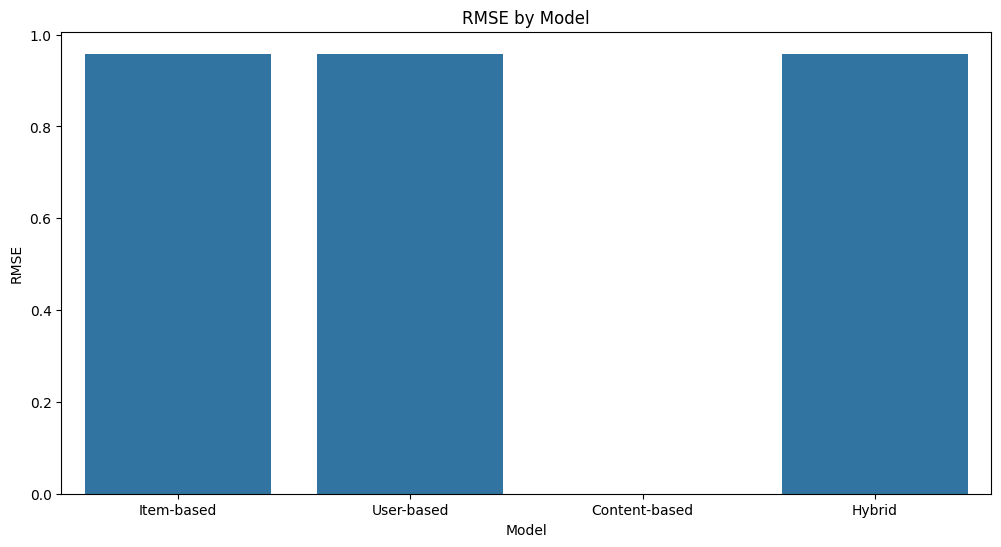

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(results_df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Precision@K', data=results_df)
    plt.title('Precision@5 by Model')
    plt.savefig('precision_plot.png')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Recall@K', data=results_df)
    plt.title('Recall@5 by Model')
    plt.savefig('recall_plot.png')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='F1@K', data=results_df)
    plt.title('F1@5 by Model')
    plt.savefig('f1_plot.png')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='RMSE', data=results_df)
    plt.title('RMSE by Model')
    plt.savefig('rmse_plot.png')
    # Визуализация
visualize_results(results_df)

In [77]:
# Функция для гибридной фильтрации
def hybrid_filtering(train_ratings, movies_df, user_id, top_n=5, weights=None):
    if weights is None:
        weights = {'item_based': 0.4, 'user_based': 0.3, 'content_based': 0.3}
    
    item_based_recs = item_based_collaborative_filtering(train_ratings, movies_df, user_id, top_n=top_n*3)
    user_based_recs = user_based_collaborative_filtering(train_ratings, movies_df, user_id, top_n=top_n*3)
    content_based_recs = content_based_filtering(train_ratings, movies_df, user_id, top_n=top_n*3)
    
    movie_scores = {}
    for _, row in item_based_recs.iterrows():
        movie_id = row['movieId']
        movie_scores[movie_id] = movie_scores.get(movie_id, 0) + weights['item_based'] * (1 / (1 + list(item_based_recs['movieId']).index(movie_id)))
    
    for _, row in user_based_recs.iterrows():
        movie_id = row['movieId']
        movie_scores[movie_id] = movie_scores.get(movie_id, 0) + weights['user_based'] * (1 / (1 + list(user_based_recs['movieId']).index(movie_id)))
    
    for _, row in content_based_recs.iterrows():
        movie_id = row['movieId']
        movie_scores[movie_id] = movie_scores.get(movie_id, 0) + weights['content_based'] * (1 / (1 + list(content_based_recs['movieId']).index(movie_id)))
    
    hybrid_scores = pd.DataFrame(list(movie_scores.items()), columns=['movieId', 'score'])
    hybrid_scores = hybrid_scores.sort_values(by='score', ascending=False).head(top_n)
    recommendations = movies_df[movies_df['movieId'].isin(hybrid_scores['movieId'])][['movieId', 'title']]
    
    return recommendations

In [78]:
def evaluate_models_with_weights(train_ratings, test_ratings, movies_df, k=5):
    weight_combinations = [
        {'name': 'Equal Weights', 'weights': {'item_based': 0.33, 'user_based': 0.33, 'content_based': 0.34}},
        {'name': 'Item-based Heavy', 'weights': {'item_based': 0.6, 'user_based': 0.2, 'content_based': 0.2}},
        {'name': 'User-based Heavy', 'weights': {'item_based': 0.2, 'user_based': 0.6, 'content_based': 0.2}},
        {'name': 'Content-based Heavy', 'weights': {'item_based': 0.2, 'user_based': 0.2, 'content_based': 0.6}},
        {'name': 'Balanced', 'weights': {'item_based': 0.4, 'user_based': 0.3, 'content_based': 0.3}}
    ]
    
    results = {'Model': [], 'Precision@K': [], 'Recall@K': [], 'F1@K': [], 'RMSE': []}
    
    test_high_rated = test_ratings[test_ratings['rating'] >= 4][['userId', 'movieId']]
    user_true_items = test_high_rated.groupby('userId')['movieId'].apply(list).to_dict()
    
    global_mean_rating = train_ratings['rating'].mean()
    test_users = test_ratings['userId'].unique()
    
    for weight_combo in weight_combinations:
        model_name = f"Hybrid ({weight_combo['name']})"
        precisions, recalls, f1s, rmses = [], [], [], []
        
        for user_id in test_users[:100]:
            recommendations = hybrid_filtering(train_ratings, movies_df, user_id, top_n=k, weights=weight_combo['weights'])
            recommended_items = recommendations['movieId'].tolist()
            true_items = user_true_items.get(user_id, [])
            
            if true_items:
                precision, recall, f1 = evaluate_recommendations(recommended_items, true_items, k)
                precisions.append(precision)
                recalls.append(recall)
                f1s.append(f1)
            
            user_test_ratings = test_ratings[test_ratings['userId'] == user_id]
            true_ratings = user_test_ratings['rating'].values
            predicted_ratings = []
            
            for _, row in user_test_ratings.iterrows():
                movie_id = row['movieId']
                item_pred = train_ratings[train_ratings['movieId'] == movie_id]['rating'].mean()
                user_pred = train_ratings[train_ratings['movieId'] == movie_id]['rating'].mean()
                pred_rating = (item_pred + user_pred) / 2 if not (pd.isna(item_pred) or pd.isna(user_pred)) else global_mean_rating
                pred_rating = pred_rating if not pd.isna(pred_rating) else global_mean_rating
                predicted_ratings.append(pred_rating)
            
            if predicted_ratings and not np.any(np.isnan(true_ratings)):
                rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
                rmses.append(rmse)
        
        results['Model'].append(model_name)
        results['Precision@K'].append(np.mean(precisions) if precisions else 0)
        results['Recall@K'].append(np.mean(recalls) if recalls else 0)
        results['F1@K'].append(np.mean(f1s) if f1s else 0)
        results['RMSE'].append(np.mean(rmses) if rmses else np.nan)
    
    return pd.DataFrame(results)

In [79]:
# Визуализация результатов
def visualize_results(results_df):
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Precision@K', y='Model', data=results_df)
    plt.title('Precision@5 by Hybrid Model Weights')
    plt.savefig('precision_plot.png')
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Recall@K', y='Model', data=results_df)
    plt.title('Recall@5 by Hybrid Model Weights')
    plt.savefig('recall_plot.png')
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='F1@K', y='Model', data=results_df)
    plt.title('F1@5 by Hybrid Model Weights')
    plt.savefig('f1_plot.png')
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='RMSE', y='Model', data=results_df)
    plt.title('RMSE by Hybrid Model Weights')
    plt.savefig('rmse_plot.png')


Hybrid Model Evaluation Results with Different Weights:
                          Model  Precision@K  Recall@K      F1@K      RMSE
0        Hybrid (Equal Weights)        0.216  0.049034  0.068022  0.958401
1     Hybrid (Item-based Heavy)        0.262  0.062004  0.084924  0.958401
2     Hybrid (User-based Heavy)        0.260  0.054516  0.077612  0.958401
3  Hybrid (Content-based Heavy)        0.158  0.035142  0.047956  0.958401
4             Hybrid (Balanced)        0.256  0.058667  0.081669  0.958401


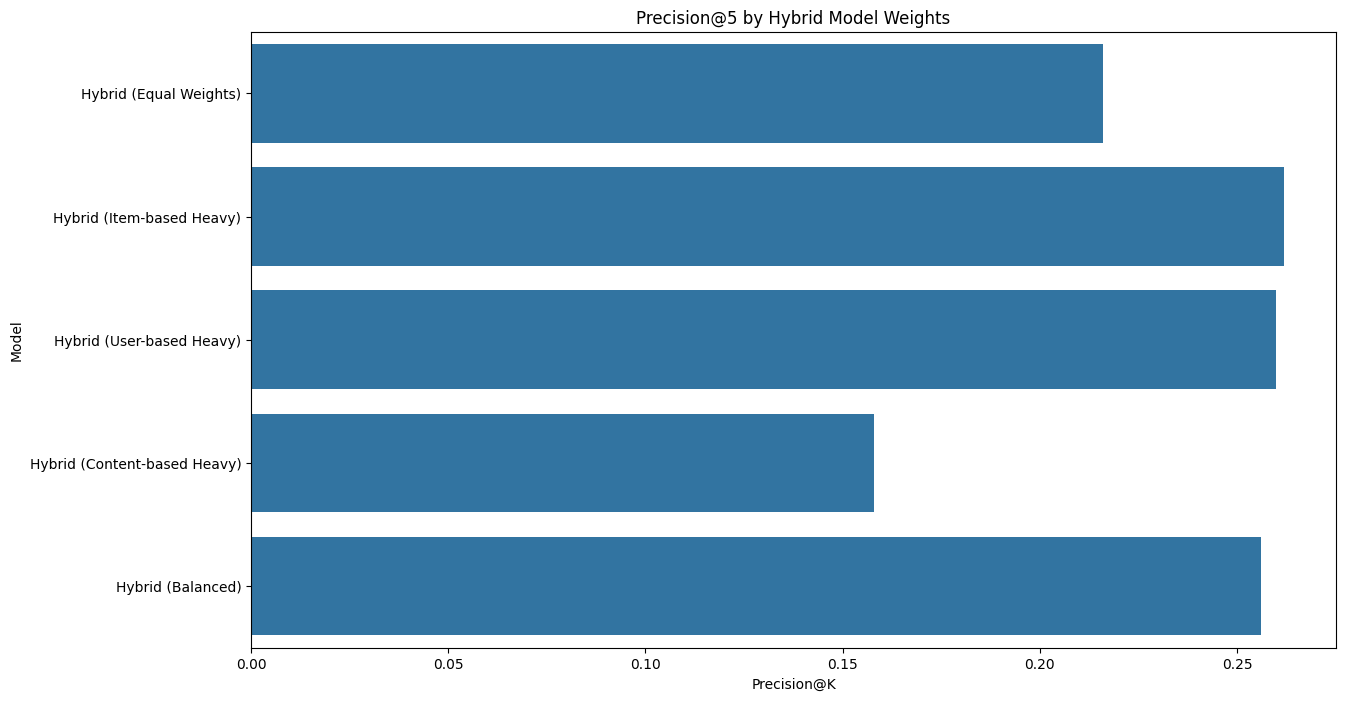

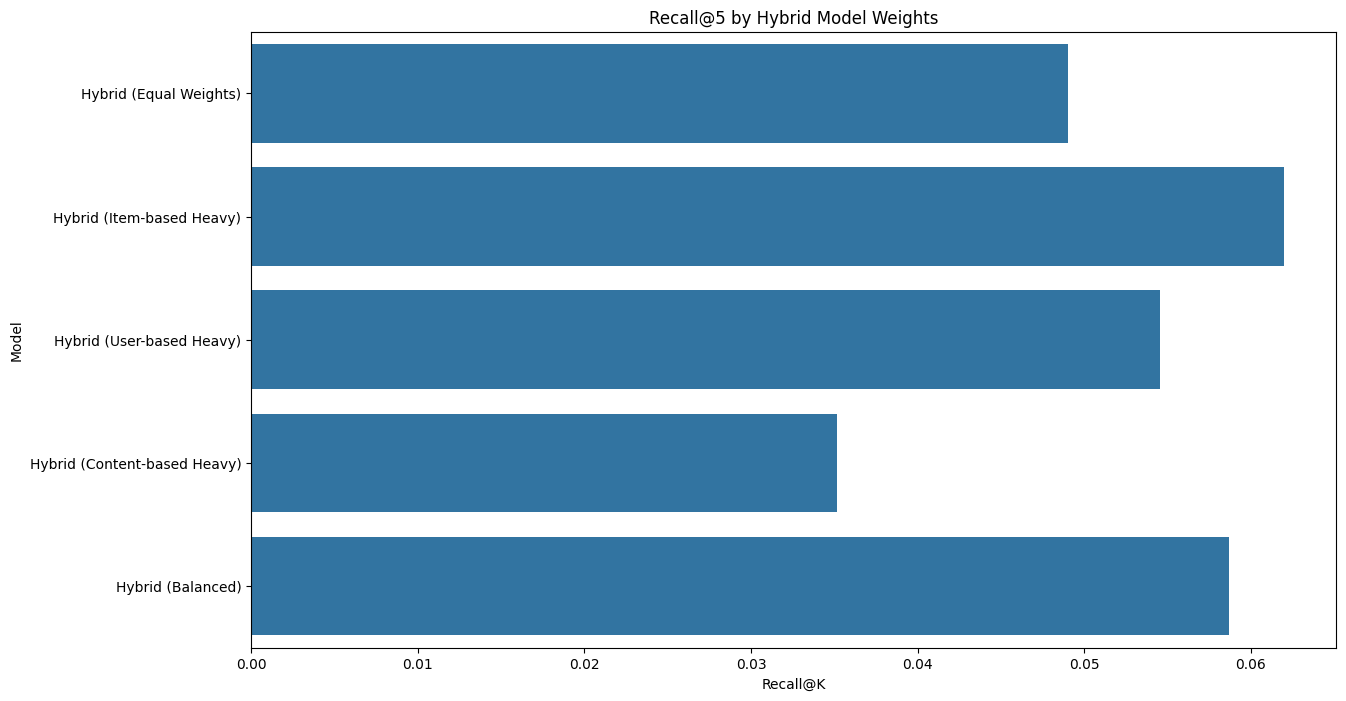

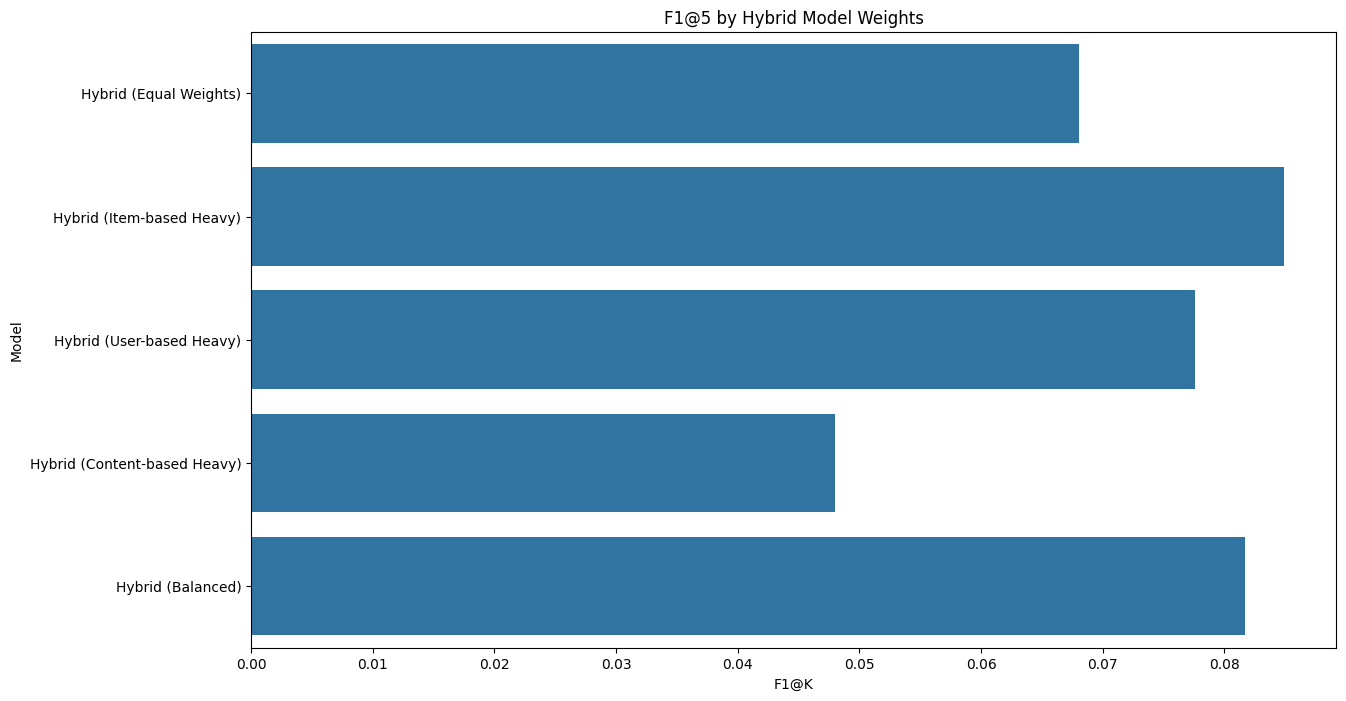

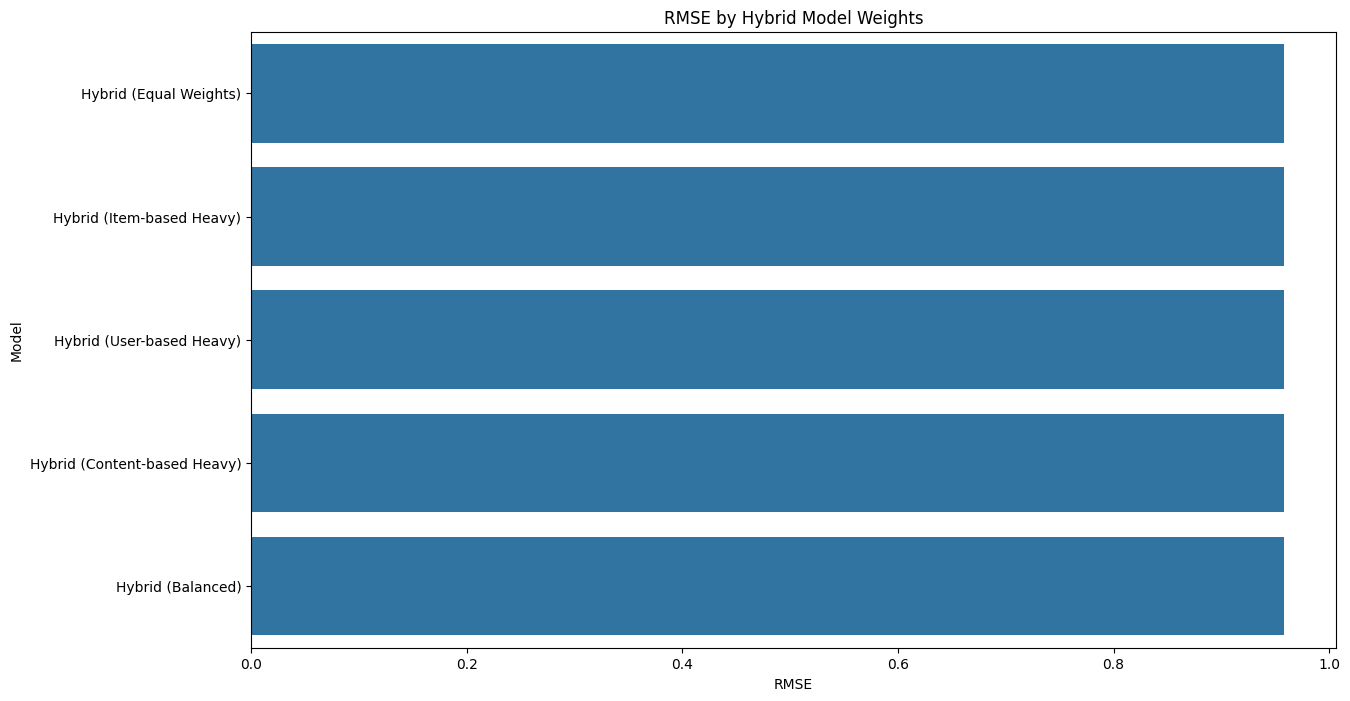

In [80]:
# Оценка моделей
results_df = evaluate_models_with_weights(train_ratings, test_ratings, movies_df, k=5)
print("\nHybrid Model Evaluation Results with Different Weights:")
print(results_df)

# Визуализация
visualize_results(results_df)


Model Evaluation Results (Base Models + Hybrid with Different Weights):
                          Model  Precision@K  Recall@K      F1@K
0                    Item-based        0.302  0.081900  0.102191
1                    User-based        0.346  0.092900  0.117542
2                 Content-based        0.016  0.003073  0.004535
3        Hybrid (Equal Weights)        0.216  0.049034  0.068022
4     Hybrid (Item-based Heavy)        0.262  0.062004  0.084924
5     Hybrid (User-based Heavy)        0.260  0.054516  0.077612
6  Hybrid (Content-based Heavy)        0.158  0.035142  0.047956
7             Hybrid (Balanced)        0.256  0.058667  0.081669


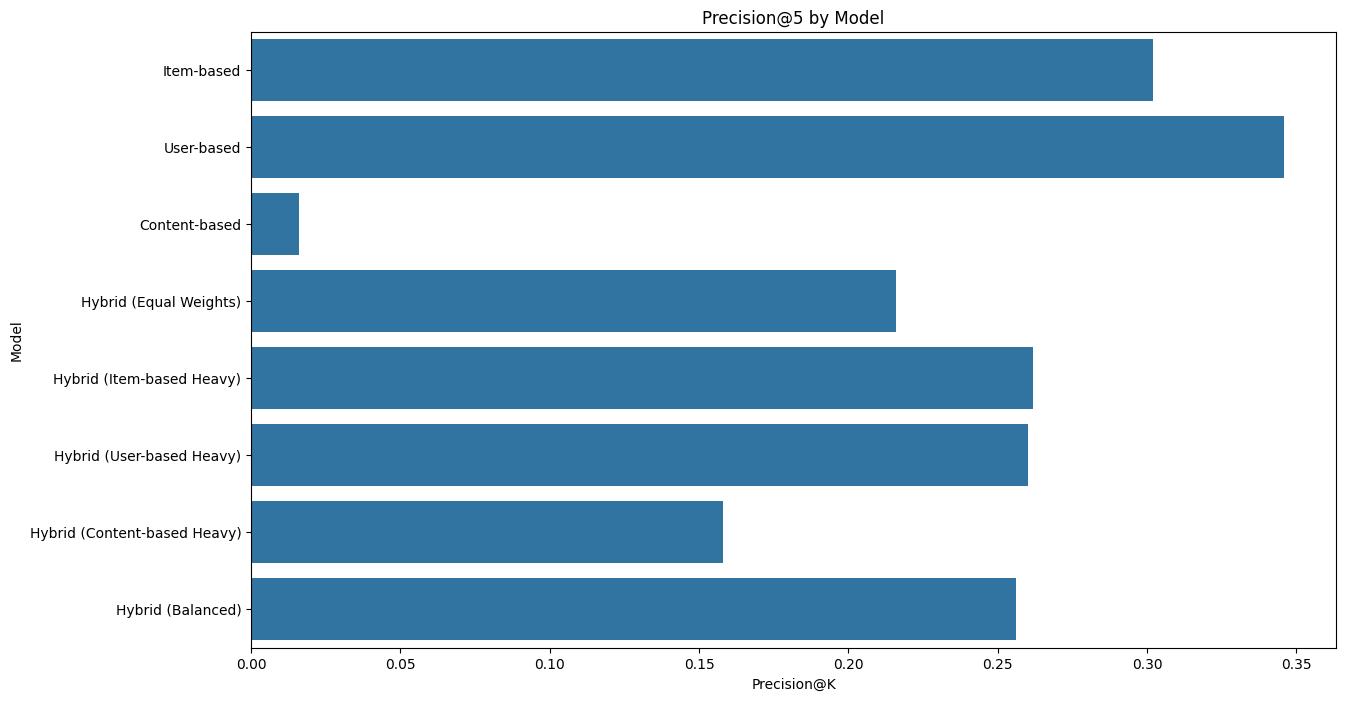

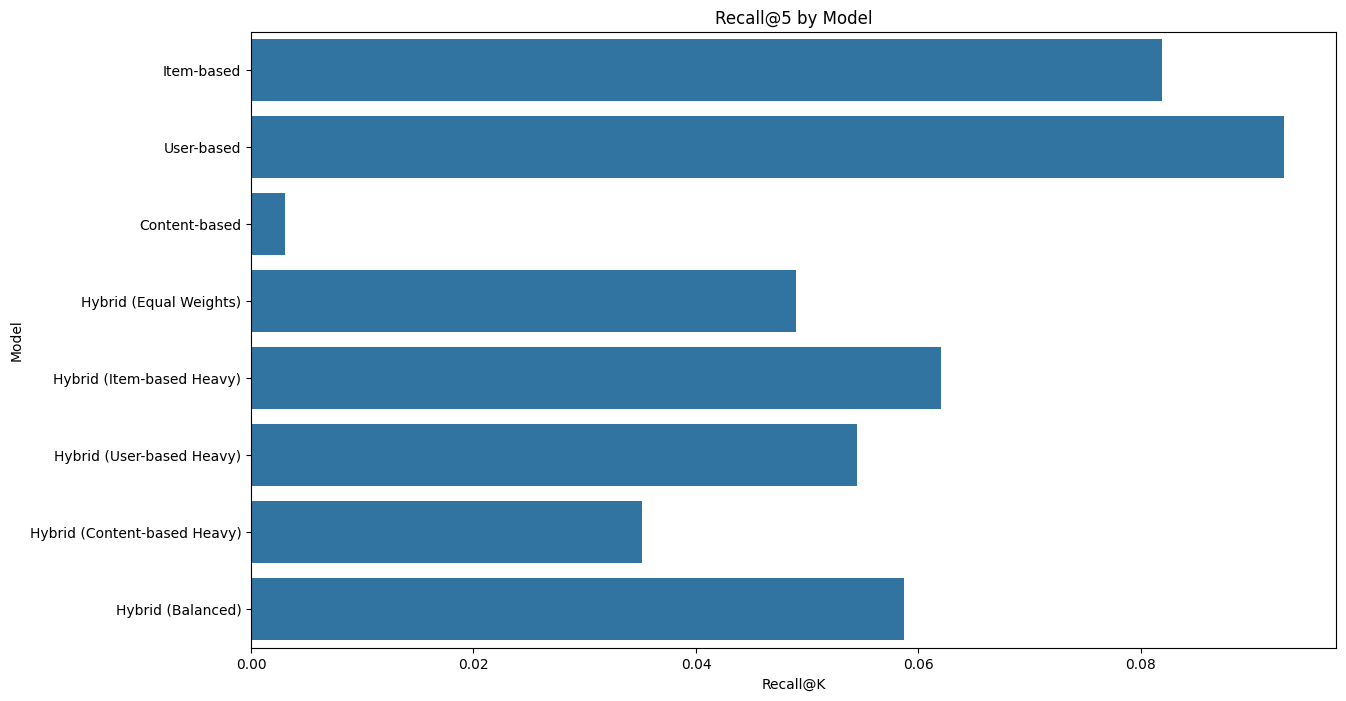

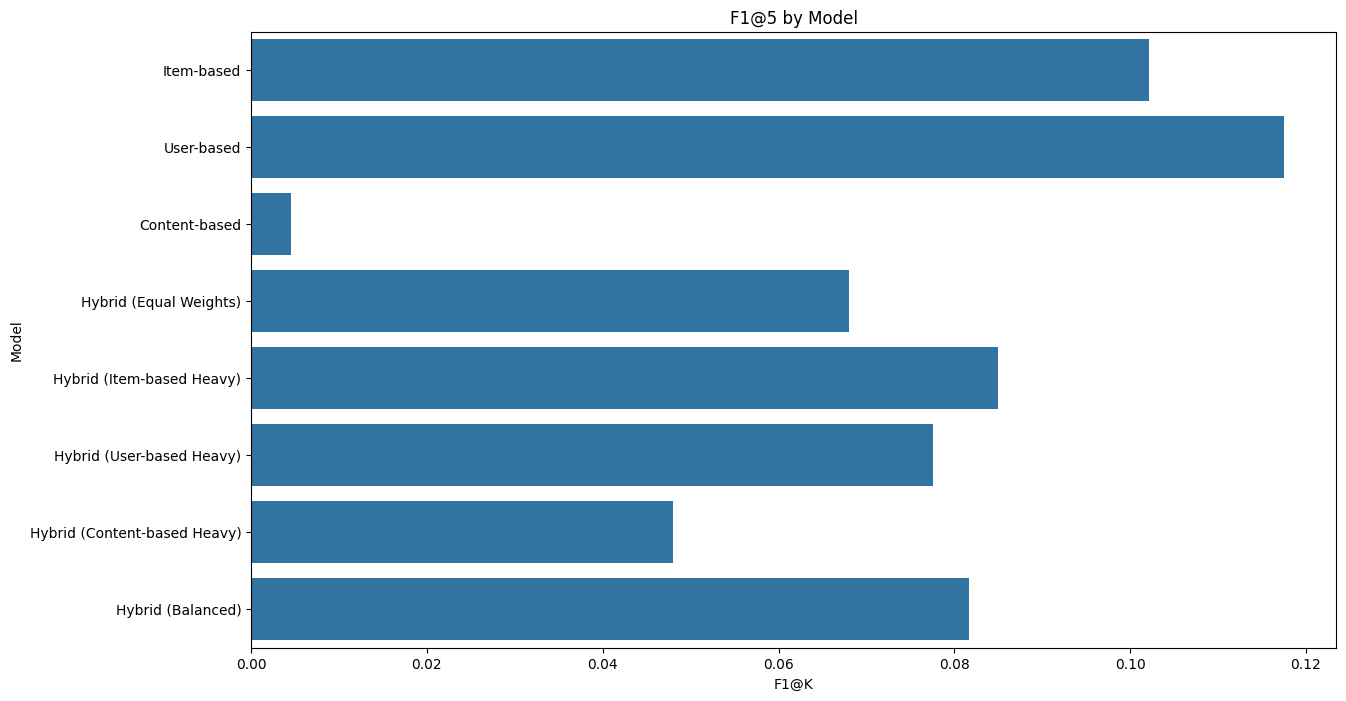

In [92]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Функции для базовых методов
def item_based_collaborative_filtering(ratings_df, movies_df, user_id, top_n=5):
    user_item_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    item_similarity = cosine_similarity(user_item_matrix.T)
    item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)
    
    user_ratings = user_item_matrix.loc[user_id]
    rated_items = user_ratings[user_ratings > 0].index
    
    scores = pd.Series(0.0, index=user_item_matrix.columns)
    for item in rated_items:
        similar_scores = item_similarity_df[item] * user_ratings[item]
        scores = scores.add(similar_scores, fill_value=0)
    
    scores = scores.drop(rated_items, errors='ignore')
    top_items = scores.sort_values(ascending=False).head(top_n)
    recommendations = movies_df[movies_df['movieId'].isin(top_items.index)][['movieId', 'title']]
    
    return recommendations

def user_based_collaborative_filtering(ratings_df, movies_df, user_id, top_n=5):
    user_item_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    user_similarity = cosine_similarity(user_item_matrix)
    user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)
    
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:11]
    recommendations = pd.Series(dtype=float)
    for sim_user, similarity in similar_users.items():
        user_ratings = user_item_matrix.loc[sim_user]
        rated_items = user_ratings[user_ratings > 0]
        recommendations = recommendations.add(rated_items * similarity, fill_value=0)
    
    user_rated = user_item_matrix.loc[user_id]
    recommendations = recommendations[user_rated == 0]
    top_items = recommendations.sort_values(ascending=False).head(top_n).index
    recommendations = movies_df[movies_df['movieId'].isin(top_items)][['movieId', 'title']]
    
    return recommendations

def content_based_filtering(ratings_df, movies_df, user_id, top_n=5):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(movies_df['content'])
    content_similarity = cosine_similarity(tfidf_matrix)
    content_similarity_df = pd.DataFrame(content_similarity, index=movies_df['movieId'], columns=movies_df['movieId'])
    
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    high_rated = user_ratings[user_ratings['rating'] >= 4]['movieId']
    
    scores = pd.Series(0.0, index=movies_df['movieId'])
    for movie_id in high_rated:
        similar_scores = content_similarity_df[movie_id]
        scores = scores.add(similar_scores, fill_value=0)
    
    scores = scores.drop(high_rated, errors='ignore')
    top_items = scores.sort_values(ascending=False).head(top_n).index
    recommendations = movies_df[movies_df['movieId'].isin(top_items)][['movieId', 'title']]
    
    return recommendations

# Функция для гибридной фильтрации
def hybrid_filtering(train_ratings, movies_df, user_id, top_n=5, weights=None):
    if weights is None:
        weights = {'item_based': 0.4, 'user_based': 0.3, 'content_based': 0.3}
    
    item_based_recs = item_based_collaborative_filtering(train_ratings, movies_df, user_id, top_n=top_n*3)
    user_based_recs = user_based_collaborative_filtering(train_ratings, movies_df, user_id, top_n=top_n*3)
    content_based_recs = content_based_filtering(train_ratings, movies_df, user_id, top_n=top_n*3)
    
    movie_scores = {}
    for _, row in item_based_recs.iterrows():
        movie_id = row['movieId']
        movie_scores[movie_id] = movie_scores.get(movie_id, 0) + weights['item_based'] * (1 / (1 + list(item_based_recs['movieId']).index(movie_id)))
    
    for _, row in user_based_recs.iterrows():
        movie_id = row['movieId']
        movie_scores[movie_id] = movie_scores.get(movie_id, 0) + weights['user_based'] * (1 / (1 + list(user_based_recs['movieId']).index(movie_id)))
    
    for _, row in content_based_recs.iterrows():
        movie_id = row['movieId']
        movie_scores[movie_id] = movie_scores.get(movie_id, 0) + weights['content_based'] * (1 / (1 + list(content_based_recs['movieId']).index(movie_id)))
    
    hybrid_scores = pd.DataFrame(list(movie_scores.items()), columns=['movieId', 'score'])
    hybrid_scores = hybrid_scores.sort_values(by='score', ascending=False).head(top_n)
    recommendations = movies_df[movies_df['movieId'].isin(hybrid_scores['movieId'])][['movieId', 'title']]
    
    return recommendations

# Функция для оценки рекомендаций
def evaluate_recommendations(recommended_items, true_items, k=5):
    recommended_k = recommended_items[:k]
    relevant = set(true_items)
    recommended_set = set(recommended_k)
    
    true_positive = len(recommended_set & relevant)
    precision = true_positive / k if k > 0 else 0
    recall = true_positive / len(relevant) if len(relevant) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

# Function to evaluate all models (without RMSE)
def evaluate_models_with_weights(train_ratings, test_ratings, movies_df, k=5):
    weight_combinations = [
        {'name': 'Equal Weights', 'weights': {'item_based': 0.33, 'user_based': 0.33, 'content_based': 0.34}},
        {'name': 'Item-based Heavy', 'weights': {'item_based': 0.6, 'user_based': 0.2, 'content_based': 0.2}},
        {'name': 'User-based Heavy', 'weights': {'item_based': 0.2, 'user_based': 0.6, 'content_based': 0.2}},
        {'name': 'Content-based Heavy', 'weights': {'item_based': 0.2, 'user_based': 0.2, 'content_based': 0.6}},
        {'name': 'Balanced', 'weights': {'item_based': 0.4, 'user_based': 0.3, 'content_based': 0.3}}
    ]
    
    models = [
        {'name': 'Item-based', 'func': item_based_collaborative_filtering, 'hybrid': False},
        {'name': 'User-based', 'func': user_based_collaborative_filtering, 'hybrid': False},
        {'name': 'Content-based', 'func': content_based_filtering, 'hybrid': False}
    ] + [{'name': f"Hybrid ({wc['name']})", 'func': hybrid_filtering, 'weights': wc['weights'], 'hybrid': True} 
         for wc in weight_combinations]
    
    results = {'Model': [], 'Precision@K': [], 'Recall@K': [], 'F1@K': []}
    
    test_high_rated = test_ratings[test_ratings['rating'] >= 4][['userId', 'movieId']]
    user_true_items = test_high_rated.groupby('userId')['movieId'].apply(list).to_dict()
    
    test_users = test_ratings['userId'].unique()
    
    for model in models:
        model_name = model['name']
        precisions, recalls, f1s = [], [], []
        
        for user_id in test_users[:100]:
            # Generate recommendations
            if model['hybrid']:
                recommendations = model['func'](train_ratings, movies_df, user_id, top_n=k, weights=model['weights'])
            else:
                recommendations = model['func'](train_ratings, movies_df, user_id, top_n=k)
            
            recommended_items = recommendations['movieId'].tolist()
            true_items = user_true_items.get(user_id, [])
            
            # Compute Precision, Recall, F1
            if true_items:
                precision, recall, f1 = evaluate_recommendations(recommended_items, true_items, k)
                precisions.append(precision)
                recalls.append(recall)
                f1s.append(f1)
        
        # Append results
        results['Model'].append(model_name)
        results['Precision@K'].append(np.mean(precisions) if precisions else 0)
        results['Recall@K'].append(np.mean(recalls) if recalls else 0)
        results['F1@K'].append(np.mean(f1s) if f1s else 0)
    
    return pd.DataFrame(results)

# Visualization function
def visualize_results(results_df):
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Precision@K', y='Model', data=results_df)
    plt.title('Precision@5 by Model')
    plt.savefig('precision_plot.png')
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Recall@K', y='Model', data=results_df)
    plt.title('Recall@5 by Model')
    plt.savefig('recall_plot.png')
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='F1@K', y='Model', data=results_df)
    plt.title('F1@5 by Model')
    plt.savefig('f1_plot.png')

# Data loading and preprocessing
movies_path = 'movies (1).csv'
ratings_path = 'ratings 2.csv'

movies_df = pd.read_csv(movies_path)
ratings_df = pd.read_csv(ratings_path)

movies_df.dropna(subset=['title', 'genres'], inplace=True)
movies_df['genres'] = movies_df['genres'].str.replace('|', ' ')
movies_df['content'] = movies_df['title'] + ' ' + movies_df['genres']

# Train-test split
train_ratings, test_ratings = train_test_split(ratings_df, test_size=0.2, random_state=42)

# Evaluate models
results_df = evaluate_models_with_weights(train_ratings, test_ratings, movies_df, k=5)
print("\nModel Evaluation Results (Base Models + Hybrid with Different Weights):")
print(results_df)

# Visualize results
visualize_results(results_df)

Number of test groups: 50
Number of active users: 555
Number of users with relevant items: 608
Number of relevant ratings: 16318
Intersection of movieIds (train vs test): 4401
Model: Item-based, Group: [541, 8, 514], Watched: 116, True items: 82, True in train: 81
Recommended items: 20, [296, 356, 480, 1097, 1196, 1198, 1210, 1214, 1240, 1265, 1270, 1291, 1682, 1968, 2115, 2716, 2985, 2987, 3033, 3527]
Intersection: {356}
Precision: 0.05, Recall: 0.012195121951219513, F1: 0.019607843137254905
Model: Item-based, Group: [63, 292, 545], Watched: 141, True items: 104, True in train: 104
Recommended items: 20, [1198, 1210, 1265, 1270, 1291, 1527, 1580, 1682, 2716, 2959, 3033, 3793, 4896, 4963, 5349, 5378, 5989, 6539, 8636, 34048]
Intersection: {1580}
Precision: 0.05, Recall: 0.009615384615384616, F1: 0.016129032258064516
Model: Item-based, Group: [419, 379, 475], Watched: 75, True items: 70, True in train: 65
Recommended items: 20, [356, 1198, 1270, 1527, 1580, 1682, 2571, 2959, 3578, 3793,

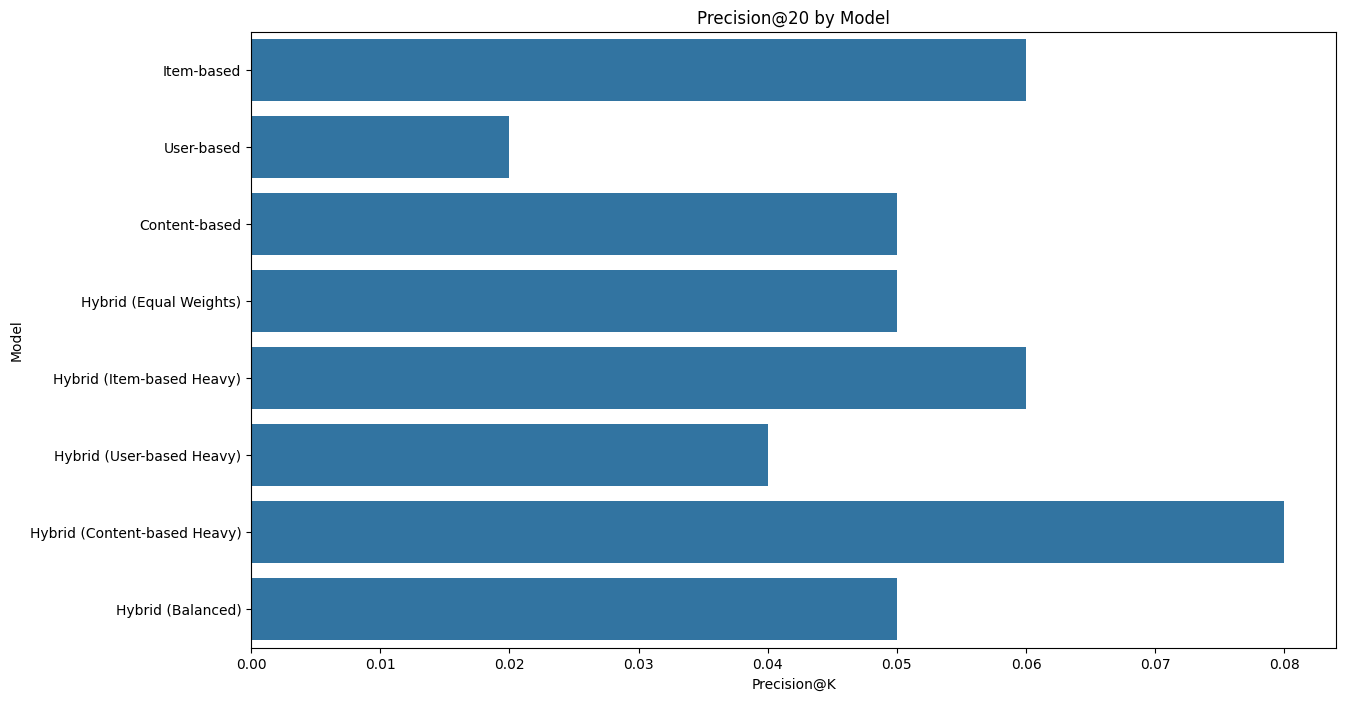

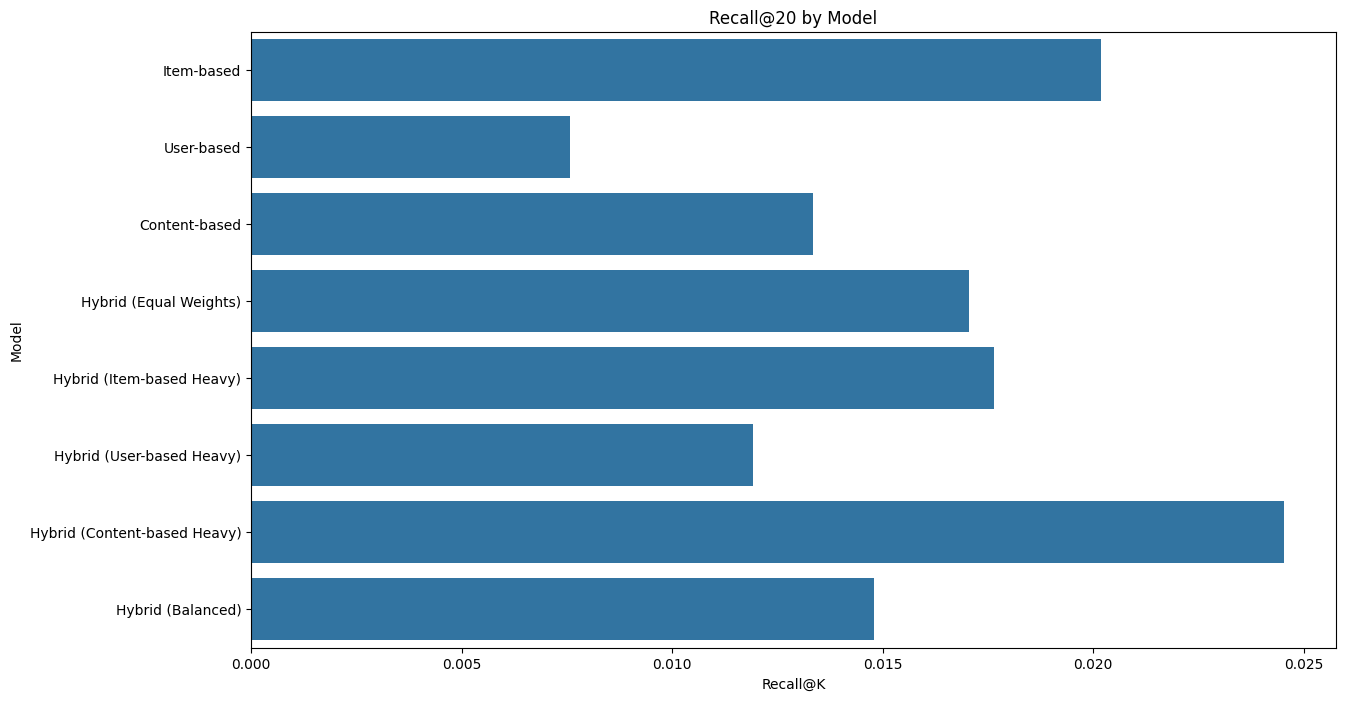

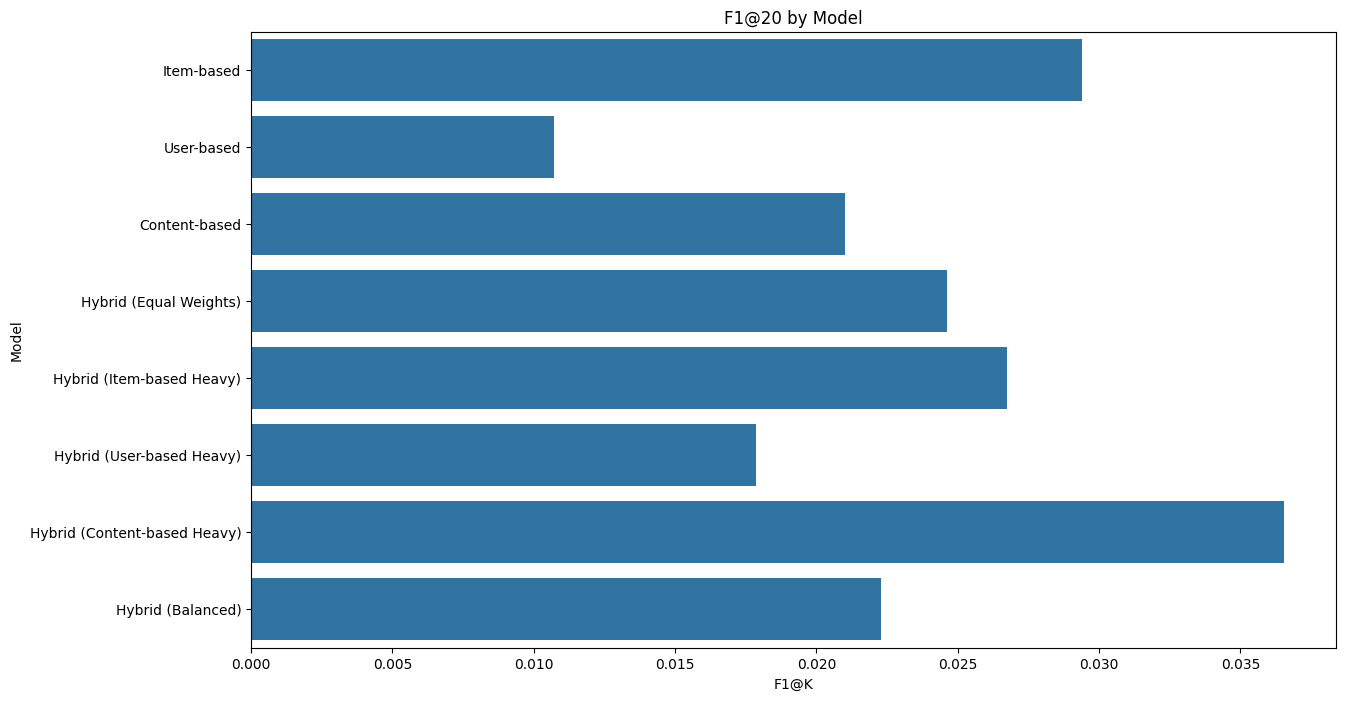

In [89]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Функции для базовых методов
def item_based_collaborative_filtering(ratings_df, movies_df, user_ids, watched_movies, top_n=20):
    user_item_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    
    group_rated_items = set(watched_movies)
    for user_id in user_ids:
        if user_id in user_item_matrix.index:
            rated_items = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
            group_rated_items.update(rated_items)
    
    item_similarity = cosine_similarity(user_item_matrix.T)
    item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)
    
    scores = pd.Series(0.0, index=user_item_matrix.columns)
    for item in group_rated_items:
        if item in item_similarity_df.index:
            similar_scores = item_similarity_df[item]
            scores = scores.add(similar_scores, fill_value=0)
    
    top_items = scores.sort_values(ascending=False).head(top_n).index
    recommendations = movies_df[movies_df['movieId'].isin(top_items)][['movieId', 'title']]
    
    return recommendations

def user_based_collaborative_filtering(ratings_df, movies_df, user_ids, watched_movies, top_n=20):
    user_item_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    
    user_similarity = cosine_similarity(user_item_matrix)
    user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)
    
    recommendations = pd.Series(dtype=float)
    for user_id in user_ids:
        if user_id in user_similarity_df.index:
            similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:11]
            for sim_user, similarity in similar_users.items():
                user_ratings = user_item_matrix.loc[sim_user]
                rated_items = user_ratings[user_ratings > 0]
                recommendations = recommendations.add(rated_items * similarity, fill_value=0)
    
    for movie_id in watched_movies:
        if movie_id in user_item_matrix.columns:
            movie_vector = user_item_matrix[movie_id]
            recommendations = recommendations.add(movie_vector, fill_value=0)
    
    top_items = recommendations.sort_values(ascending=False).head(top_n).index
    recommendations = movies_df[movies_df['movieId'].isin(top_items)][['movieId', 'title']]
    
    return recommendations

def content_based_filtering(ratings_df, movies_df, user_ids, watched_movies, top_n=20):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(movies_df['content'])
    content_similarity = cosine_similarity(tfidf_matrix)
    content_similarity_df = pd.DataFrame(content_similarity, index=movies_df['movieId'], columns=movies_df['movieId'])
    
    group_rated_items = set(watched_movies)
    for user_id in user_ids:
        user_ratings = ratings_df[ratings_df['userId'] == user_id]
        high_rated = user_ratings[user_ratings['rating'] >= 3]['movieId']
        group_rated_items.update(high_rated)
    
    scores = pd.Series(0.0, index=movies_df['movieId'])
    for movie_id in group_rated_items:
        if movie_id in content_similarity_df.index:
            similar_scores = content_similarity_df[movie_id]
            scores = scores.add(similar_scores, fill_value=0)
    
    top_items = scores.sort_values(ascending=False).head(top_n).index
    recommendations = movies_df[movies_df['movieId'].isin(top_items)][['movieId', 'title']]
    
    return recommendations

# Функция для гибридной фильтрации
def hybrid_filtering(train_ratings, movies_df, user_ids, watched_movies, top_n=20, weights=None):
    if weights is None:
        weights = {'item_based': 0.4, 'user_based': 0.3, 'content_based': 0.3}
    
    item_based_recs = item_based_collaborative_filtering(train_ratings, movies_df, user_ids, watched_movies, top_n=top_n*3)
    user_based_recs = user_based_collaborative_filtering(train_ratings, movies_df, user_ids, watched_movies, top_n=top_n*3)
    content_based_recs = content_based_filtering(train_ratings, movies_df, user_ids, watched_movies, top_n=top_n*3)
    
    movie_scores = {}
    for _, row in item_based_recs.iterrows():
        movie_id = row['movieId']
        movie_scores[movie_id] = movie_scores.get(movie_id, 0) + weights['item_based'] * (1 / (1 + list(item_based_recs['movieId']).index(movie_id)))
    
    for _, row in user_based_recs.iterrows():
        movie_id = row['movieId']
        movie_scores[movie_id] = movie_scores.get(movie_id, 0) + weights['user_based'] * (1 / (1 + list(user_based_recs['movieId']).index(movie_id)))
    
    for _, row in content_based_recs.iterrows():
        movie_id = row['movieId']
        movie_scores[movie_id] = movie_scores.get(movie_id, 0) + weights['content_based'] * (1 / (1 + list(content_based_recs['movieId']).index(movie_id)))
    
    hybrid_scores = pd.DataFrame(list(movie_scores.items()), columns=['movieId', 'score'])
    hybrid_scores = hybrid_scores.sort_values(by='score', ascending=False).head(top_n)
    recommendations = movies_df[movies_df['movieId'].isin(hybrid_scores['movieId'])][['movieId', 'title']]
    
    return recommendations

# Функция для оценки рекомендаций
def evaluate_recommendations(recommended_items, true_items, k=20):
    recommended_k = recommended_items[:k]
    relevant = set(true_items)
    recommended_set = set(recommended_k)
    
    true_positive = len(recommended_set & relevant)
    precision = true_positive / k if k > 0 else 0
    recall = true_positive / len(relevant) if len(relevant) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

# Функция для оценки всех моделей
def evaluate_models_with_weights(train_ratings, test_ratings, movies_df, k=20):
    weight_combinations = [
        {'name': 'Equal Weights', 'weights': {'item_based': 0.33, 'user_based': 0.33, 'content_based': 0.34}},
        {'name': 'Item-based Heavy', 'weights': {'item_based': 0.6, 'user_based': 0.2, 'content_based': 0.2}},
        {'name': 'User-based Heavy', 'weights': {'item_based': 0.2, 'user_based': 0.6, 'content_based': 0.2}},
        {'name': 'Content-based Heavy', 'weights': {'item_based': 0.2, 'user_based': 0.2, 'content_based': 0.6}},
        {'name': 'Balanced', 'weights': {'item_based': 0.4, 'user_based': 0.3, 'content_based': 0.3}}
    ]
    
    models = [
        {'name': 'Item-based', 'func': item_based_collaborative_filtering, 'hybrid': False},
        {'name': 'User-based', 'func': user_based_collaborative_filtering, 'hybrid': False},
        {'name': 'Content-based', 'func': content_based_filtering, 'hybrid': False}
    ] + [{'name': f"Hybrid ({wc['name']})", 'func': hybrid_filtering, 'weights': wc['weights'], 'hybrid': True} for wc in weight_combinations]
    
    results = {'Model': [], 'Precision@K': [], 'Recall@K': [], 'F1@K': []}
    
    test_high_rated = test_ratings[test_ratings['rating'] >= 3][['userId', 'movieId']]
    user_true_items = test_high_rated.groupby('userId')['movieId'].apply(list).to_dict()
    
    test_users = test_ratings['userId'].unique()
    
    np.random.seed(42)
    group_size = 3
    user_rating_counts = test_ratings['userId'].value_counts()
    active_users = user_rating_counts[user_rating_counts >= 5].index
    test_groups = [np.random.choice(active_users, size=group_size, replace=False).tolist() for _ in range(50)]
    
    print(f"Number of test groups: {len(test_groups)}")
    print(f"Number of active users: {len(active_users)}")
    print(f"Number of users with relevant items: {len(user_true_items)}")
    print(f"Number of relevant ratings: {test_high_rated.shape[0]}")
    print(f"Intersection of movieIds (train vs test): {len(set(train_ratings['movieId']) & set(test_ratings['movieId']))}")
    
    for model in models:
        model_name = model['name']
        precisions, recalls, f1s = [], [], []
        
        for idx, group_users in enumerate(test_groups[:5]):
            group_watched = set()
            group_true_items = set()
            for user_id in group_users:
                user_test_ratings = test_ratings[test_ratings['userId'] == user_id]
                group_watched.update(user_test_ratings['movieId'].tolist())
                if user_id in user_true_items:
                    group_true_items.update(user_true_items[user_id])
            
            train_true_intersection = len(set(group_true_items) & set(train_ratings['movieId'].unique()))
            print(f"Model: {model_name}, Group: {group_users}, Watched: {len(group_watched)}, True items: {len(group_true_items)}, True in train: {train_true_intersection}")
            
            if model['hybrid']:
                recommendations = model['func'](train_ratings, movies_df, group_users, group_watched, top_n=k, weights=model['weights'])
            else:
                recommendations = model['func'](train_ratings, movies_df, group_users, group_watched, top_n=k)
            
            recommended_items = recommendations['movieId'].tolist()
            intersection = set(recommended_items) & set(group_true_items)
            print(f"Recommended items: {len(recommended_items)}, {recommended_items}")
            print(f"Intersection: {intersection}")
            
            if group_true_items:
                precision, recall, f1 = evaluate_recommendations(recommended_items, group_true_items, k)
                precisions.append(precision)
                recalls.append(recall)
                f1s.append(f1)
                print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")
            
        results['Model'].append(model_name)
        results['Precision@K'].append(np.mean(precisions) if precisions else 0)
        results['Recall@K'].append(np.mean(recalls) if recalls else 0)
        results['F1@K'].append(np.mean(f1s) if f1s else 0)
    
    return pd.DataFrame(results)

# Визуализация результатов
def visualize_results(results_df):
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Precision@K', y='Model', data=results_df)
    plt.title('Precision@20 by Model')
    plt.savefig('precision_plot.png')
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Recall@K', y='Model', data=results_df)
    plt.title('Recall@20 by Model')
    plt.savefig('recall_plot.png')
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x='F1@K', y='Model', data=results_df)
    plt.title('F1@20 by Model')
    plt.savefig('f1_plot.png')

# Загрузка и предобработка данных
movies_path = 'movies (1).csv'
ratings_path = 'ratings 2.csv'

movies_df = pd.read_csv(movies_path)
ratings_df = pd.read_csv(ratings_path)

movies_df.dropna(subset=['title', 'genres'], inplace=True)
movies_df['genres'] = movies_df['genres'].str.replace('|', ' ')
movies_df['content'] = movies_df['title'] + ' ' + movies_df['genres']

# Разделение данных
train_ratings, test_ratings = train_test_split(ratings_df, test_size=0.2, random_state=42)

# Оценка моделей
results_df = evaluate_models_with_weights(train_ratings, test_ratings, movies_df, k=20)
print("\nModel Evaluation Results (Base Models + Hybrid with Different Weights for Group Recommendations):")
print(results_df)

# Визуализация
visualize_results(results_df)